In [3]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rankdata, genpareto
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from arch import arch_model
import scipy.stats as stats

In [4]:
df_cleaned = pd.read_excel("India_Opec.xlsx")

In [5]:
missing_values = df_cleaned.isnull().sum()
print(missing_values)

Date             0
Close_nifty    611
OPEC_INR       489
dtype: int64


In [6]:
# Drop rows where both 'Close_cac' and 'Brent_Euro' are NaN
df = df_cleaned.dropna(how='all', subset=['Close_nifty', 'OPEC_INR'])

In [7]:
missing_values = df.isnull().sum()
print(missing_values)

Date             0
Close_nifty    396
OPEC_INR       274
dtype: int64


In [8]:
#Define the date ranges
pre_covid_start = '2015-01-01'
pre_covid_end = '2020-02-29'
covid_start = '2020-03-01'
covid_end = '2022-02-28'
post_covid_start = '2022-03-01'
post_covid_end = '2024-03-31'

In [9]:
# Filter the data
pre_covid_data = df[(df['Date'] >= pre_covid_start) & (df['Date'] <= pre_covid_end)]
covid_data = df[(df['Date'] >= covid_start) & (df['Date'] <= covid_end)]
post_covid_data = df[(df['Date'] >= post_covid_start) & (df['Date'] <= post_covid_end)]

In [10]:
missing_values = covid_data.isnull().sum()
print(missing_values)

Date            0
Close_nifty    76
OPEC_INR       57
dtype: int64


In [11]:
df.head()

,Date,Close_nifty,OPEC_INR
0,2015-01-05,8378.400391,3990.396133
1,2015-01-06,8127.350098,3876.897801
2,2015-01-07,8102.100098,3835.217623
3,2015-01-08,8234.599609,NaN
4,2015-01-09,8284.500000,3065.096178


In [14]:
# Forward fill missing values
covid_data.fillna(method='ffill', inplace=True)

C:\Users\KASHISH NIGAM\AppData\Local\Temp\ipykernel_1988\575695476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data.fillna(method='ffill', inplace=True)


In [15]:
missing_values = covid_data.isnull().sum()
print(missing_values)

Date           0
Close_nifty    1
OPEC_INR       0
dtype: int64


In [16]:
# Delete row where Date is '2020-03-01'
covid_data = covid_data[covid_data['Date'] != '2020-03-01']

# Display cleaned DataFrame
print("\nDataFrame after deleting the row with Date '2020-03-01':")
print(covid_data)


DataFrame after deleting the row with Date '2020-03-01':
           Date   Close_nifty     OPEC_INR
1415 2020-03-02  11132.750000  4114.901108
1416 2020-03-03  11303.299805  3902.227487
1417 2020-03-04  11251.000000  1705.094084
1418 2020-03-05  11269.000000  1705.094084
1419 2020-03-06  10989.450195  2628.408829
...         ...           ...          ...
2818 2021-06-12  16793.900391  5282.742276
2821 2022-01-02  16793.900391  7091.102177
2826 2022-02-05  16793.900391  8652.842371
2831 2022-01-08  16793.900391  8394.255293
2836 2022-02-12  16793.900391  6590.433580

[571 rows x 3 columns]


In [17]:
missing_values = covid_data.isnull().sum()
print(missing_values)

Date           0
Close_nifty    0
OPEC_INR       0
dtype: int64


## ADF TEST

In [18]:
time_series_columns = ['Close_nifty', 'OPEC_INR']

def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Loop over each column and perform ADF test
for column in time_series_columns:
    print(f"ADF Test Results for {column}:")
    adf_test(covid_data[column])
    print()

ADF Test Results for Close_nifty:
ADF Statistic: -0.7155447499435347
p-value: 0.8426819059626479
Critical Values:
   1%: -3.441935806025943
   5%: -2.8666509204896093
   10%: -2.5694919649816947

ADF Test Results for OPEC_INR:
ADF Statistic: -3.028502523885431
p-value: 0.032317003042802696
Critical Values:
   1%: -3.441935806025943
   5%: -2.8666509204896093
   10%: -2.5694919649816947



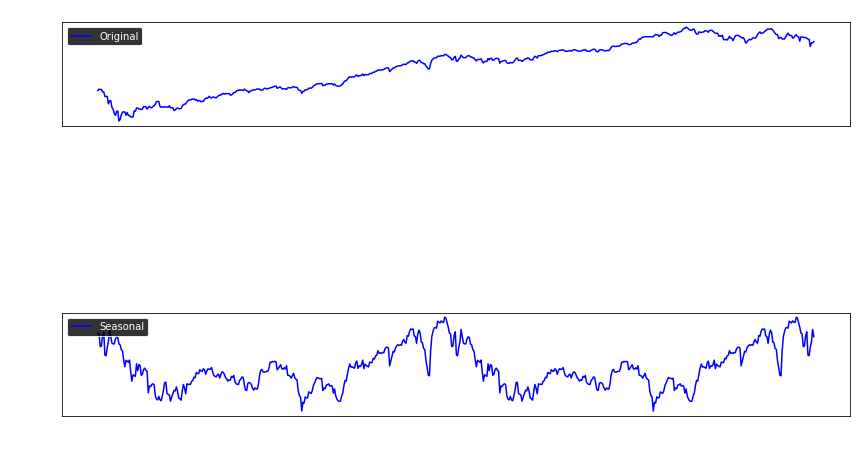

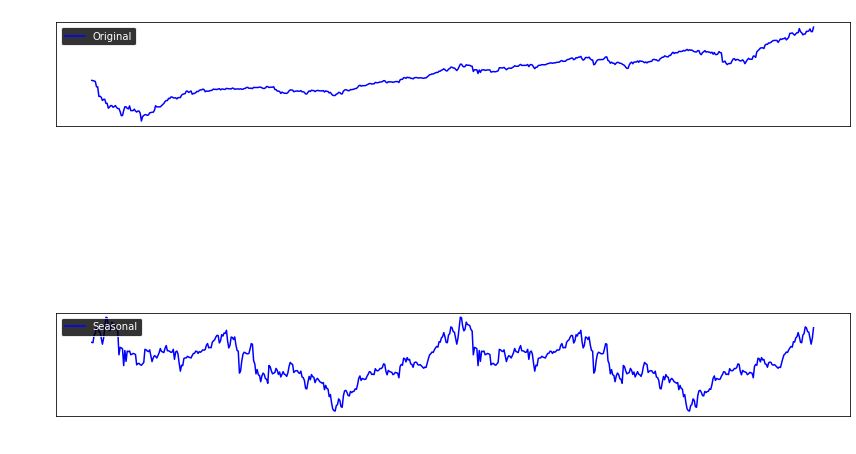

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose the time series for Close_nifty
result_nifty = seasonal_decompose(covid_data['Close_nifty'], model='additive', period=300)

# Plot the decomposed components for Close_nifty
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(covid_data['Close_nifty'], label='Original', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Original', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.title('Time Series Decomposition - Close_nifty', color='white')

plt.subplot(413)
plt.plot(result_nifty.seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Seasonal', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Date', color='white')

plt.tight_layout()
plt.show()

# Decompose the time series for Brent_INR
result_brent = seasonal_decompose(covid_data['Brent_INR'], model='additive', period=300)

# Plot the decomposed components for Brent_INR
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(covid_data['Brent_INR'], label='Original', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Original', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.title('Time Series Decomposition - Brent_INR', color='white')

plt.subplot(413)
plt.plot(result_brent.seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Seasonal', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Date', color='white')

plt.tight_layout()
plt.show()


####  SUMMARY

In [19]:
summary = covid_data.describe()
print(summary)

        Close_nifty     OPEC_INR
count    571.000000   571.000000
mean   14145.018746  4430.354300
std     2943.358817  1589.843915
min     7610.250000   905.530192
25%    11397.950195  3196.032501
50%    14736.400391  4620.273825
75%    16793.900391  5427.287568
max    18477.050781  9201.455685


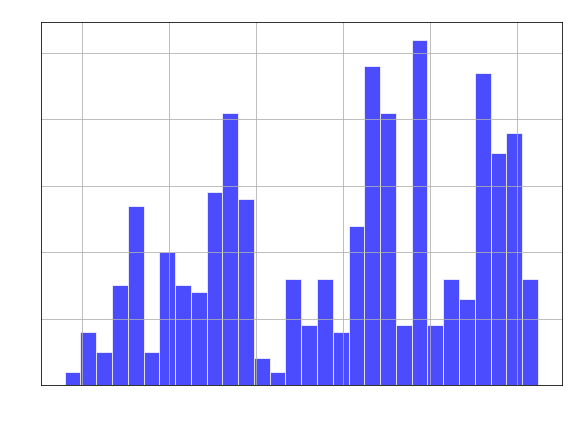

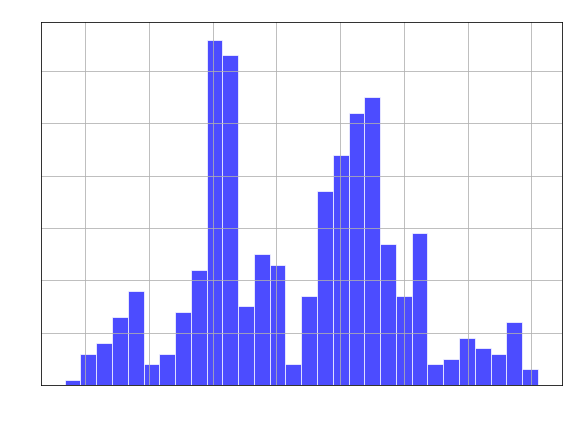

In [15]:
import matplotlib.pyplot as plt

# Plot histogram for 'Close_nifty'
plt.figure(figsize=(8, 6))
plt.hist(covid_data['Close_nifty'], bins=30, color='blue', edgecolor='white', alpha=0.7)

# Add labels and title
plt.xlabel('Close_nifty', color='white')
plt.ylabel('Frequency', color='white')
plt.title('Histogram of Close_nifty', color='white')

# Customize tick parameters to be white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot histogram for 'Brent_INR'
plt.figure(figsize=(8, 6))
plt.hist(covid_data['Brent_INR'], bins=30, color='blue', edgecolor='white', alpha=0.7)

# Add labels and title
plt.xlabel('Brent_INR', color='white')
plt.ylabel('Frequency', color='white')
plt.title('Histogram of Brent_INR', color='white')

# Customize tick parameters to be white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
covid_data = covid_data.copy()
covid_data['Log_Return_Close_nifty'] = np.log(covid_data['Close_nifty'] / covid_data['Close_nifty'].shift(1))
covid_data['Log_Return_OPEC_INR'] = np.log(covid_data['OPEC_INR'] / covid_data['OPEC_INR'].shift(1))

In [21]:
missing_values = covid_data.isnull().sum()
print(missing_values)

Date                      0
Close_nifty               0
OPEC_INR                  0
Log_Return_Close_nifty    1
Log_Return_OPEC_INR       1
dtype: int64


In [22]:
covid_data = covid_data.dropna()

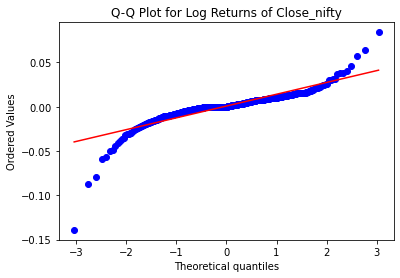

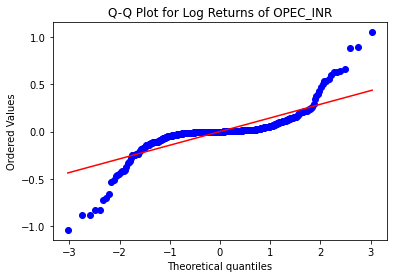

In [23]:
import scipy.stats as stats
# Plot Q-Q plot for 'Log_Return_Close_nifty'
stats.probplot(covid_data['Log_Return_Close_nifty'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Log Returns of Close_nifty')
plt.show()

# Plot Q-Q plot for 'Log_Return_Brent_INR'
stats.probplot(covid_data['Log_Return_OPEC_INR'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Log Returns of OPEC_INR')
plt.show()

In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

# KPSS Test
def kpss_test(series, title=''):
    print(f'KPSS Test: {title}')
    result = kpss(series, regression='c', nlags="auto")
    labels = ['KPSS Statistic', 'p-value', 'Lags Used']
    out = pd.Series(result[:3], index=labels)
    for key, value in result[3].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

In [25]:
# Perform ADF test for Close_nifty log returns
adf_test(covid_data['Log_Return_Close_nifty'], title='Log Return Close_nifty')

# Perform KPSS test for Close_nifty log returns
kpss_test(covid_data['Log_Return_Close_nifty'], title='Log Return Close_nifty')

# Perform ADF test for Brent_INR log returns
adf_test(covid_data['Log_Return_OPEC_INR'], title='Log Return OPEC_INR')

# Perform KPSS test for Brent_INR log returns
kpss_test(covid_data['Log_Return_OPEC_INR'], title='Log Return OPEC_INR')

Augmented Dickey-Fuller Test: Log Return Close_nifty
ADF Statistic                 -7.860426e+00
p-value                        5.302370e-12
#Lags Used                     1.900000e+01
Number of Observations Used    5.500000e+02
Critical Value (1%)           -3.442296e+00
Critical Value (5%)           -2.866809e+00
Critical Value (10%)          -2.569576e+00
dtype: float64

KPSS Test: Log Return Close_nifty
KPSS Statistic           0.111985
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Augmented Dickey-Fuller Test: Log Return OPEC_INR
ADF Statistic                 -8.499219e+00
p-value                        1.251480e-13
#Lags Used                     1.900000e+01
Number of Observations Used    5.500000e+02
Critical Value (1%)           -3.442296e+00
Critical Value (5%)           -2.866809e+00
Critical Value (10%) 

C:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [26]:
# Rescale the log returns
covid_data['Log_Return_Close_nifty_scaled'] = covid_data['Log_Return_Close_nifty'] * 100
covid_data['Log_Return_OPEC_INR_scaled'] = covid_data['Log_Return_OPEC_INR'] * 100

In [27]:
from arch import arch_model
# Refit the models with the rescaled data
model_close_nifty_scaled = arch_model(covid_data['Log_Return_Close_nifty_scaled'], vol='Garch', p=1, o=1, q=1)
results_close_nifty_scaled = model_close_nifty_scaled.fit(disp='off')
print(results_close_nifty_scaled.summary())

model_OPEC_inr_scaled = arch_model(covid_data['Log_Return_OPEC_INR_scaled'], vol='Garch', p=1, o=1, q=1)
results_OPEC_inr_scaled = model_OPEC_inr_scaled.fit(disp='off')
print(results_OPEC_inr_scaled.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:     Log_Return_Close_nifty_scaled   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -850.368
Distribution:                             Normal   AIC:                           1710.74
Method:                       Maximum Likelihood   BIC:                           1732.47
                                                   No. Observations:                  570
Date:                           Tue, Jun 04 2024   Df Residuals:                      569
Time:                                   18:15:21   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

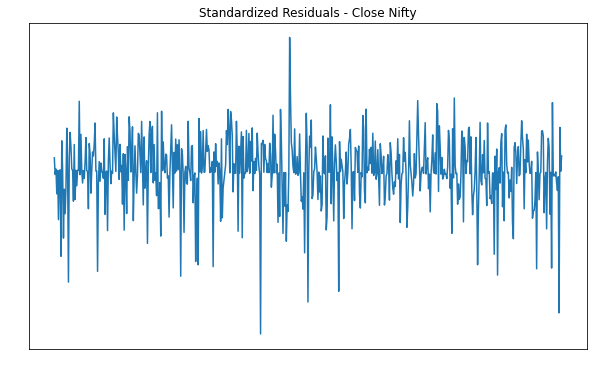

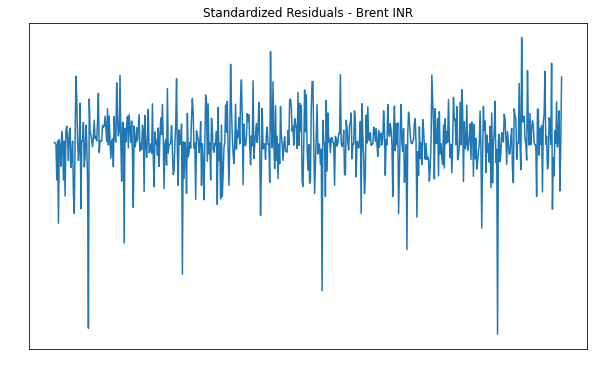

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(results_close_nifty_scaled.resid / results_close_nifty_scaled.conditional_volatility)
plt.tick_params(axis='x', colors='white')  # Set x-axis ticks color to white
plt.tick_params(axis='y', colors='white')  # Set y-axis ticks color to white
plt.title('Standardized Residuals - Close Nifty')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_brent_inr_scaled.resid / results_brent_inr_scaled.conditional_volatility)
plt.tick_params(axis='x', colors='white')  # Set x-axis ticks color to white
plt.tick_params(axis='y', colors='white')  # Set y-axis ticks color to white
plt.title('Standardized Residuals - Brent INR')
plt.show()

In [28]:
# Assuming `results` is the fitted GJR-GARCH model for Close_nifty
standardized_residuals_nifty = results_close_nifty_scaled.resid / results_close_nifty_scaled.conditional_volatility

# Assuming `results_brent` is the fitted GJR-GARCH model for Brent_INR
standardized_residuals_OPEC = results_OPEC_inr_scaled.resid / results_OPEC_inr_scaled.conditional_volatility


<AxesSubplot:ylabel='Density'>

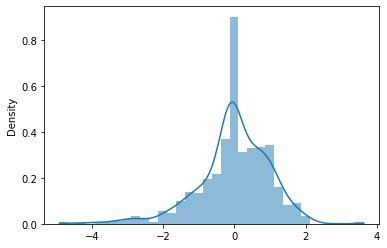

In [29]:
sns.histplot(standardized_residuals_nifty, kde=True, stat="density", linewidth=0)


<AxesSubplot:ylabel='Density'>

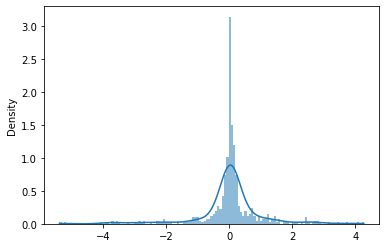

In [30]:
sns.histplot(standardized_residuals_OPEC, kde=True, stat="density", linewidth=0)

In [31]:
# Creating a DataFrame for easy handling
standardized_residuals = pd.DataFrame({
    'Nifty': standardized_residuals_nifty,
    'OPEC': standardized_residuals_OPEC
})

# @@@@@@@@@@@@@@@@@@@@@@@@@

((array([-3.25494947, -2.9940664 , -2.84875745, ...,  2.84875745,
          2.9940664 ,  3.25494947]),
  array([-6.39690939, -6.20573411, -5.01824716, ...,  2.94051099,
          3.40440338,  4.04135301])),
 (0.9669909858162249, -0.016668692305852727, 0.9637040694997204))

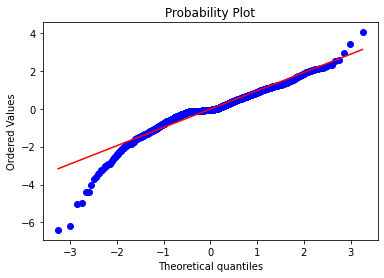

In [30]:
# Q-Q plot
import scipy.stats as stats
stats.probplot(standardized_residuals.values.ravel(), dist="norm", plot=plt)

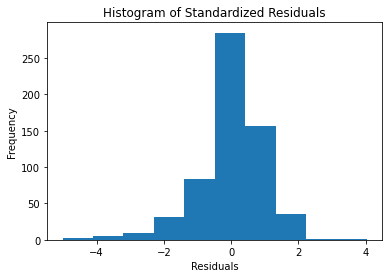

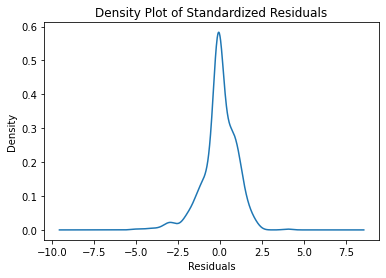

Skewness: -0.8855107396676382
Kurtosis: 2.9007023135318755


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Histogram
plt.hist(standardized_residuals['Nifty'], bins=10)
plt.title('Histogram of Standardized Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Density Plot
standardized_residuals['Nifty'].plot(kind='density')
plt.title('Density Plot of Standardized Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Skewness
skew = standardized_residuals['Nifty'].skew()
print("Skewness:", skew)

# Kurtosis
kurt = standardized_residuals['Nifty'].kurtosis()
print("Kurtosis:", kurt)

In [32]:
# # It seems you've provided the skewness and kurtosis values for a dataset. 
#Skewness measures the asymmetry of the distribution, with negative values indicating a left-skewed 
#distribution (longer tail on the left) and positive values indicating a right-skewed distribution 
#(longer tail on the right). Kurtosis measures the peakedness of the distribution, with higher values 
#indicating more extreme tails compared to a normal distribution.

# # Based on the provided values:

# # Skewness: -0.8855
# # This negative skewness suggests that the distribution is left-skewed, meaning it 
#has a longer tail on the left side and the majority of the values are concentrated on the right 
#side of the distribution.
# # Kurtosis: 2.9007
# # This positive kurtosis indicates that the distribution has heavier tails and a sharper peak 
#compared to a normal distribution. It suggests that there are more extreme values present in the dataset, 
#leading to a higher kurtosis.

# # These moments provide insights into the shape and characteristics of the dataset's distribution, 
#which can be useful for further analysis and modeling.

# Yes, based on the provided skewness and kurtosis values, it's evident that the data is asymmetrical 
#and not normally distributed:

# 1. **Asymmetry (Skewness)**: The negative skewness value (-0.8855) 
#indicates that the distribution is left-skewed. This means that the tail of the distribution extends 
#to the left, and the majority of the data points are concentrated on the 
#right side of the distribution. In other words, there is a higher frequency of values below the 
#mean than above it.

# 2. **Normality (Kurtosis)**: The positive kurtosis value (2.9007) suggests that the distribution 
#has heavier tails and a sharper peak compared to a normal distribution. 
#This indicates that the data has more extreme values than would be expected in a normal distribution. 

# These observations collectively indicate that the data is asymmetrical and deviates 
#from a normal distribution. This information is valuable for understanding the underlying 
#characteristics of the dataset and for selecting appropriate statistical methods for analysis.

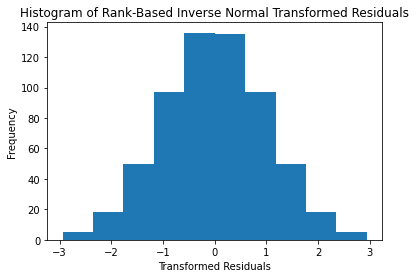

In [33]:
# Rank Based Inverse Normal transformation
from scipy.stats import norm

# Rank data and convert to percentile
ranked_residuals = standardized_residuals['Nifty'].rank(method='average')
percentiles = ranked_residuals / (len(ranked_residuals) + 1)

# Apply inverse normal transformation
inv_norm_residuals_nifty = norm.ppf(percentiles)

# Check the transformation results
plt.hist(inv_norm_residuals_nifty, bins=10)
plt.title('Histogram of Rank-Based Inverse Normal Transformed Residuals')
plt.xlabel('Transformed Residuals')
plt.ylabel('Frequency')
plt.show()

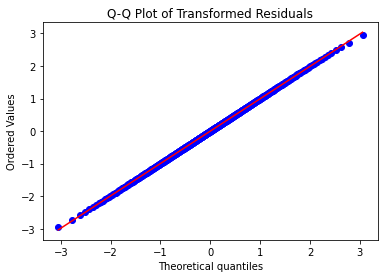

Shapiro-Wilk test: Statistic=0.9995759430223657, p-value=0.9999908195222429


In [34]:
import scipy.stats as stats

# Q-Q plot
stats.probplot(inv_norm_residuals_nifty, dist="norm", plot=plt)
plt.title('Q-Q Plot of Transformed Residuals')
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(inv_norm_residuals_nifty)
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

In [35]:
# The Shapiro-Wilk test is a statistical test used to assess whether a given sample of data comes from a normally distributed population. In this test, the null hypothesis is that the data is normally distributed. A high p-value (typically above 0.05) suggests that there is no significant evidence to reject the null hypothesis, indicating that the data is likely normally distributed.

# Based on the provided Shapiro-Wilk test results:

# - **Statistic**: 0.9995759430223657
# - **p-value**: 0.9999908195222429

# The p-value is very high (close to 1), indicating strong evidence in favor of the null hypothesis. Therefore, we fail to reject the null hypothesis and conclude that there is no significant evidence to suggest that the data deviates from a normal distribution. 

# However, it's important to note that while the Shapiro-Wilk test is sensitive to departures from normality, it may not be very powerful for large sample sizes. Therefore, even though the p-value is high, it's still valuable to consider other indicators of normality, such as skewness, kurtosis, and visual inspection of the data, especially if the sample size is large.

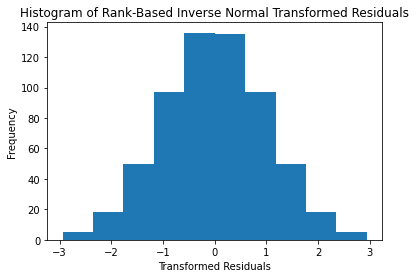

In [36]:
# Rank Based Inverse Normal transformation
from scipy.stats import norm

# Rank data and convert to percentile
ranked_residuals = standardized_residuals['Brent'].rank(method='average')
percentiles = ranked_residuals / (len(ranked_residuals) + 1)

# Apply inverse normal transformation
inv_norm_residuals_brent = norm.ppf(percentiles)

# Check the transformation results
plt.hist(inv_norm_residuals_brent, bins=10)
plt.title('Histogram of Rank-Based Inverse Normal Transformed Residuals')
plt.xlabel('Transformed Residuals')
plt.ylabel('Frequency')
plt.show()

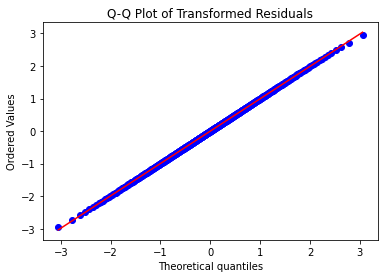

Shapiro-Wilk test: Statistic=0.9995759430223653, p-value=0.9999908195222428


In [37]:
import scipy.stats as stats

# Q-Q plot
stats.probplot(inv_norm_residuals_brent, dist="norm", plot=plt)
plt.title('Q-Q Plot of Transformed Residuals')
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(inv_norm_residuals_brent)
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

In [38]:
# # The Shapiro-Wilk test statistic and p-value you provided indicate that the test was performed on a 
# dataset to assess its normality. Here's how to interpret the results:

# # - **Statistic**: The test statistic is a value calculated from the data that measures how 
# closely the sample distribution resembles a normal distribution. In this case, 
# the test statistic is 0.9995759430223653.

# # - **p-value**: The p-value is a measure of the evidence against the null hypothesis. 
# The null hypothesis of the Shapiro-Wilk test is that the data is normally distributed. 
# A high p-value suggests that there is no significant evidence to reject the null hypothesis, 
# indicating that the data may be normally distributed. In this case, the p-value is 0.9999908195222428,
# which is very close to 1.

# # Given the high p-value, we fail to reject the null hypothesis. This means that there is 
# no significant evidence to suggest that the data deviates from a normal distribution. 
# Therefore, based on the Shapiro-Wilk test results, we can tentatively conclude that the data 
# is normally distributed. However, it's important to consider other factors such as the sample size, 
# the context of the data, and additional diagnostic tests to confirm the normality assumption.

# @@@@@@@@@@@@@@@@@@@@@@@@@

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, genpareto
from statsmodels.distributions.empirical_distribution import ECDF

In [33]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for Nifty
shapiro_nifty = shapiro(standardized_residuals['Nifty'])
print("Shapiro-Wilk test for Nifty:")
print("Test Statistic:", shapiro_nifty[0])
print("p-value:", shapiro_nifty[1])

# Perform Shapiro-Wilk test for Brent
shapiro_OPEC = shapiro(standardized_residuals['OPEC'])
print("\nShapiro-Wilk test for OPEC:")
print("Test Statistic:", shapiro_OPEC[0])
print("p-value:", shapiro_OPEC[1])

Shapiro-Wilk test for Nifty:
Test Statistic: 0.9490967773559111
p-value: 4.2177628328656973e-13

Shapiro-Wilk test for OPEC:
Test Statistic: 0.7711102325445554
p-value: 1.9440786700702138e-27


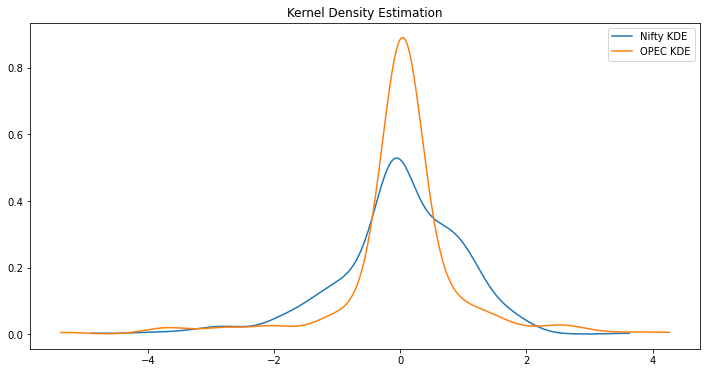

In [34]:
# # Kernel Density Estimation (KDE) for PDF
# kde_nifty = gaussian_kde(inv_norm_residuals_nifty)
# kde_brent = gaussian_kde(inv_norm_residuals_brent)

# # Plot the KDE
# x_grid_nifty = np.linspace(inv_norm_residuals_nifty.min(), inv_norm_residuals_nifty.max(), 1000)
# x_grid_brent = np.linspace(inv_norm_residuals_brent.min(), inv_norm_residuals_brent.max(), 1000)

# Kernel Density Estimation (KDE) for PDF
kde_nifty = gaussian_kde(standardized_residuals['Nifty'])
kde_OPEC = gaussian_kde(standardized_residuals['OPEC'])

# Plot the KDE
x_grid_nifty = np.linspace(standardized_residuals['Nifty'].min(), standardized_residuals['Nifty'].max(), 1000)
x_grid_OPEC = np.linspace(standardized_residuals['OPEC'].min(), standardized_residuals['OPEC'].max(), 1000)

plt.figure(figsize=(12, 6))
plt.plot(x_grid_nifty, kde_nifty(x_grid_nifty), label='Nifty KDE')
plt.plot(x_grid_OPEC, kde_OPEC(x_grid_OPEC), label='OPEC KDE')
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

In [35]:
# # Define upper and lower thresholds for 10% tails
# upper_threshold_nifty = np.percentile(inv_norm_residuals_nifty, 90)
# lower_threshold_nifty = np.percentile(inv_norm_residuals_nifty, 10)
# upper_threshold_brent = np.percentile(inv_norm_residuals_brent, 90)
# lower_threshold_brent = np.percentile(inv_norm_residuals_brent, 10)

# Define upper and lower thresholds for 10% tails
upper_threshold_nifty = np.percentile(standardized_residuals['Nifty'], 90)
lower_threshold_nifty = np.percentile(standardized_residuals['Nifty'], 10)
upper_threshold_OPEC = np.percentile(standardized_residuals['OPEC'], 90)
lower_threshold_OPEC = np.percentile(standardized_residuals['OPEC'], 10)

In [36]:
# # Extract tails for GPD fitting
# nifty_upper_tail = inv_norm_residuals_nifty[inv_norm_residuals_nifty > upper_threshold_nifty] - upper_threshold_nifty
# nifty_lower_tail = -inv_norm_residuals_nifty[inv_norm_residuals_nifty < lower_threshold_nifty] + lower_threshold_nifty
# brent_upper_tail = inv_norm_residuals_brent[inv_norm_residuals_brent > upper_threshold_brent] - upper_threshold_brent
# brent_lower_tail = -inv_norm_residuals_brent[inv_norm_residuals_brent < lower_threshold_brent] + lower_threshold_brent

# Extract tails for GPD fitting
nifty_upper_tail = standardized_residuals['Nifty'][standardized_residuals['Nifty'] > upper_threshold_nifty] - upper_threshold_nifty
nifty_lower_tail = -standardized_residuals['Nifty'][standardized_residuals['Nifty'] < lower_threshold_nifty] + lower_threshold_nifty
OPEC_upper_tail = standardized_residuals['OPEC'][standardized_residuals['OPEC'] > upper_threshold_OPEC] - upper_threshold_OPEC
OPEC_lower_tail = -standardized_residuals['OPEC'][standardized_residuals['OPEC'] < lower_threshold_OPEC] + lower_threshold_OPEC


In [37]:
# Fit GPD to the tails
params_nifty_upper = genpareto.fit(nifty_upper_tail)
params_nifty_lower = genpareto.fit(nifty_lower_tail)
params_OPEC_upper = genpareto.fit(OPEC_upper_tail)
params_OPEC_lower = genpareto.fit(OPEC_lower_tail)

In [38]:
# from statsmodels.distributions.empirical_distribution import ECDF

# # Compute empirical CDF
# ecdf_nifty = ECDF(inv_norm_residuals_nifty)
# ecdf_brent = ECDF(inv_norm_residuals_brent)

from statsmodels.distributions.empirical_distribution import ECDF

# Compute empirical CDF
ecdf_nifty = ECDF(standardized_residuals['Nifty'])
ecdf_OPEC = ECDF(standardized_residuals['OPEC'])

In [39]:
# Function to compute combined CDF
def combined_cdf(x, ecdf, upper_threshold, lower_threshold, params_upper, params_lower):
    c_u, loc_u, scale_u = params_upper
    c_l, loc_l, scale_l = params_lower
    if x <= lower_threshold:
        return ecdf(lower_threshold) * genpareto.cdf(-x + lower_threshold, c_l, loc_l, scale_l)
    elif x <= upper_threshold:
        return ecdf(x)
    else:
        return ecdf(upper_threshold) + (1 - ecdf(upper_threshold)) * genpareto.cdf(x - upper_threshold, c_u, loc_u, scale_u)


In [40]:
# Compute the combined CDFs
# Compute the combined CDFs
cdf_nifty = [combined_cdf(x, ecdf_nifty, upper_threshold_nifty, lower_threshold_nifty, params_nifty_upper, params_nifty_lower) for x in standardized_residuals['Nifty']]
cdf_OPEC = [combined_cdf(x, ecdf_OPEC, upper_threshold_OPEC, lower_threshold_OPEC, params_OPEC_upper, params_OPEC_lower) for x in standardized_residuals['OPEC']]
# # Compute the combined CDFs
# cdf_nifty = [combined_cdf(x, ecdf_nifty, upper_threshold_nifty, lower_threshold_nifty, params_nifty_upper, params_nifty_lower) for x in inv_norm_residuals_nifty]
# cdf_brent = [combined_cdf(x, ecdf_brent, upper_threshold_brent, lower_threshold_brent, params_brent_upper, params_brent_lower) for x in inv_norm_residuals_brent]

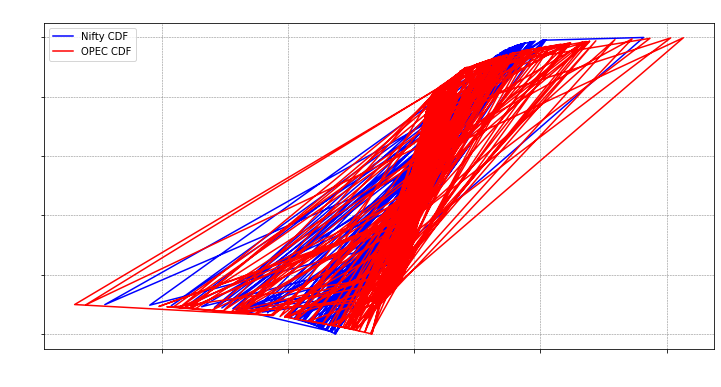

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(standardized_residuals['Nifty'], cdf_nifty, label='Nifty CDF', color='blue')
plt.plot(standardized_residuals['OPEC'], cdf_OPEC, label='OPEC CDF', color='red')
plt.title('Combined CDF with EVT-GPD Tails', color='white')
plt.legend()
plt.xlabel('Standardized Residuals', color='white')
plt.ylabel('CDF', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('white')  # Set background color to white
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add grid lines
plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(standardized_residuals['Nifty'], cdf_nifty, label='Nifty CDF', color='blue')
# plt.plot(inv_norm_residuals_brent, cdf_brent, label='Brent CDF', color='red')
# plt.title('Combined CDF with EVT-GPD Tails', color='white')
# plt.legend()
# plt.xlabel('Standardized Residuals', color='white')
# plt.ylabel('CDF', color='white')
# plt.xticks(color='white')
# plt.yticks(color='white')
# plt.gca().set_facecolor('white')  # Set background color to white
# plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add grid lines
# plt.show()

In [42]:
# Convert the CDF values to a uniform distribution for copula modeling
uniform_nifty = np.array(cdf_nifty)
uniform_OPEC = np.array(cdf_OPEC)

In [43]:
# Create a DataFrame from the uniform distributions
uniform_data = pd.DataFrame({
    'Uniform_Nifty': uniform_nifty,
    'Uniform_OPEC': uniform_OPEC
})

In [44]:
# Define the output file path
output_file = r'C:\Users\KASHISH NIGAM\Desktop\Last Sem Project\Final Datasets\India\OPEC_India\uniform_distributions-During_Covid_India.xlsx'

# Save the DataFrame to an Excel file
uniform_data.to_excel(output_file, index=False)

print(f"Uniform distributions saved to {output_file}")

Uniform distributions saved to C:\Users\KASHISH NIGAM\Desktop\Last Sem Project\Final Datasets\India\OPEC_India\uniform_distributions-During_Covid_India.xlsx
